# Un detector de imágenes muy sencillo utilizando correlación

In [1]:
a=list()
a.append([
    [0,0,0,1,1,0,0,0],
    [0,0,1,1,1,1,0,0],
    [0,1,1,0,0,1,1,0],
    [0,1,1,0,0,1,1,0],
    [0,1,1,1,1,1,1,0],
    [0,1,1,0,0,1,1,0],
    [0,1,1,0,0,1,1,0],
    [0,1,1,0,0,1,1,0]])

a.append([
    [1,1,0,0,0,0,0,0],
    [1,1,0,0,0,0,0,0],
    [1,1,0,0,0,0,0,0],
    [1,1,0,0,0,0,0,0],
    [1,1,0,0,0,0,0,0],
    [1,1,0,0,0,0,0,0],
    [1,1,1,1,1,1,1,0],
    [1,1,1,1,1,1,1,0]])

a.append([
    [1,1,1,1,1,1,1,1],
    [1,1,1,1,1,1,1,1],
    [0,0,0,1,1,0,0,0],
    [0,0,0,1,1,0,0,0],
    [0,0,0,1,1,0,0,0],
    [0,0,0,1,1,0,0,0],
    [0,0,0,1,1,0,0,0],
    [0,0,0,1,1,0,0,0]])


In [2]:
import numpy as np
import random
a=np.array(a)

In [3]:
textos=list()
labels=list()
ruido=1
size=1024
indices=[0,1,2]
for idx in range(size):
    l1=random.choice(indices)
    l2=random.choice(indices)
    l3=random.choice(indices)
    textos.append(np.hstack([a[l1],a[l2],a[l3]])+np.random.rand(8,24)*ruido)
    label=[np.zeros(3),np.zeros(3),np.zeros(3)]
    label[0][l1]=1
    label[1][l2]=1
    label[2][l3]=1
    labels.append(label)

In [4]:
labels[1][0]

array([0., 1., 0.])

In [5]:
#Visualizamos los datos g
import matplotlib.pylab as plt
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.set_aspect('equal')
plt.imshow(textos[32], cmap=plt.cm.ocean)
plt.colorbar()
plt.show()

<Figure size 640x480 with 2 Axes>

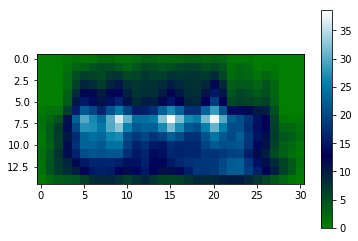

[array([1., 0., 0.]), array([0., 0., 1.]), array([0., 1., 0.])]


In [6]:
import scipy.signal as ss
corr=ss.correlate2d(textos[32],a[2])
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.set_aspect('equal')
plt.imshow(corr, cmap=plt.cm.ocean)
plt.colorbar()
plt.show()
print(labels[32])

In [7]:
train=list()
test=list()
train_labels=np.array(labels[0:924])
test_labels=np.array(labels[924:])
for texto in textos[0:924]:
    corr=np.hstack([ss.correlate2d(texto,a[0]),ss.correlate2d(texto,a[1]),ss.correlate2d(texto,a[2])])
    corr=corr.reshape([1,1395])[0]
    train.append(corr)
for texto in textos[924:]:
    corr=np.hstack([ss.correlate2d(texto,a[0]),ss.correlate2d(texto,a[1]),ss.correlate2d(texto,a[2])])
    corr=corr.reshape([1,1395])[0]
    test.append(corr)
train=np.array(train)
test=np.array(test)

In [8]:
import tensorflow as tf
import shutil
from tensorboard import summary as summary_lib
logs_path="logdir"
# Parameters
learning_rate = 0.01
training_epochs = 200
batch_size = 256
display_step = 1
hidden_units=50

# Network Parameters
n_input =  train.shape[1] # Vocab size 
n_classes = 3 # Twenty news groups # classes


with tf.name_scope("inputs"):
    # tf Graph input
    X = tf.placeholder("float", [None, n_input],name="X")
with tf.name_scope("labels"):
    YL1 = tf.placeholder("float", [None, n_classes],name="YL1")
    YL2 = tf.placeholder("float", [None, n_classes],name="YL2")
    YL3 = tf.placeholder("float", [None, n_classes],name="YL3")

# Construct model
with tf.name_scope('Capa1'):
    # Model
    weights1= tf.Variable(tf.random_normal([n_input, hidden_units]),name="weights1")
    bias1= tf.Variable(tf.random_normal([hidden_units]),name="bias1")
    act1= tf.nn.sigmoid(tf.matmul(X,weights1)+bias1, name="activacion_1")

with tf.name_scope('Letra1'):
    # Model
    weightsL1= tf.Variable(tf.random_normal([hidden_units, n_classes]),name="weightsL1")
    biasL1= tf.Variable(tf.random_normal([n_classes]),name="biasL1")
    logitsL1= tf.matmul(act1,weightsL1)+biasL1

with tf.name_scope('Letra2'):
    # Model
    weightsL2= tf.Variable(tf.random_normal([hidden_units, n_classes]),name="weightsL2")
    biasL2= tf.Variable(tf.random_normal([n_classes]),name="biasL2")
    logitsL2= tf.matmul(act1,weightsL2)+biasL2

with tf.name_scope('Letra3'):
    # Model
    weightsL3= tf.Variable(tf.random_normal([hidden_units, n_classes]),name="weightsL3")
    biasL3= tf.Variable(tf.random_normal([n_classes]),name="biasL3")
    logitsL3= tf.matmul(act1,weightsL3)+biasL3

with tf.name_scope('Loss'):
# Define loss and optimizer
    L1cost=tf.nn.softmax_cross_entropy_with_logits_v2(logits=logitsL1, labels=YL1)
    L2cost=tf.nn.softmax_cross_entropy_with_logits_v2(logits=logitsL2, labels=YL2)
    L3cost=tf.nn.softmax_cross_entropy_with_logits_v2(logits=logitsL3, labels=YL3)
    loss_op = tf.reduce_mean(L1cost+L2cost+L3cost,name="costo")
with tf.name_scope('BGD'):
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate,name="optimizador")
    train_op = optimizer.minimize(loss_op)
with tf.name_scope('Accuracy'):
    # Accuracy
    #pred = tf.nn.softmax(logits) # Softmax
    acc_op = tf.concat([tf.equal(tf.argmax(logitsL1, 1), tf.argmax(YL1, 1)),tf.equal(tf.argmax(logitsL2, 1), tf.argmax(YL2, 1)),
                        tf.equal(tf.argmax(logitsL3, 1), tf.argmax(YL3, 1))],0)
    acc_op = tf.reduce_mean(tf.cast(acc_op, tf.float32),name="acc_red_mean")
    
# Initializing the variables
init = tf.global_variables_initializer()
# Create a summary to monitor cost tensor
tf.summary.scalar("loss", loss_op)
# Create a summary to monitor accuracy tensor
tf.summary.scalar("accuracy", acc_op)
# Merge all summaries into a single op
tf.summary.histogram('histogram', weights1)
merged_summary_op = tf.summary.merge_all()

/home/cselmo/anaconda3/envs/OpLaDyn/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [9]:
with tf.Session() as sess:
    sess.run(init)
    # op to write logs to Tensorboard
    summary_writer = tf.summary.FileWriter(logs_path, graph=sess.graph)
    # Training cycle
    for epoch in range(training_epochs):
        avg_cost = 0.
        total_batch = 1
        # Loop over all batches
        for i in range(total_batch):
            #batch_x, batch_y = next_batch(batch_size,X_train_data,labels)
            # Run optimization op (backprop) and cost op (to get loss value)
            _, c= sess.run([train_op, loss_op], feed_dict={X: train, 
                                                           YL1: train_labels[:,0], 
                                                           YL2: train_labels[:,1], 
                                                           YL3: train_labels[:,2]})
            # Compute average loss
            avg_cost += c / total_batch
        # Display logs per epoch step
        if epoch % display_step == 0:
            summary, _,_ = sess.run([merged_summary_op,loss_op,acc_op],
                                  feed_dict={X: test, 
                                             YL1: test_labels[:,0], 
                                             YL2: test_labels[:,1], 
                                             YL3: test_labels[:,2]})
            summary_writer.add_summary(summary, epoch)
            print("Epoch:", '%04d' % (epoch+1), "cost={:.9f}".format(avg_cost))
    print("Optimization Finished!")

    pred = tf.concat([tf.argmax(logitsL1, 1), tf.argmax(logitsL2, 1), tf.argmax(logitsL3, 1)],0)
    truth = tf.concat([tf.argmax(YL1, 1), tf.argmax(YL2, 1), tf.argmax(YL3, 1)],0)
    accuracy = tf.equal(pred,truth)
    accuracy= tf.reduce_mean(tf.cast(acc_op, tf.float32))

    print("Accuracy:", accuracy.eval({X: test, 
                                             YL1: test_labels[:,0], 
                                             YL2: test_labels[:,1], 
                                             YL3: test_labels[:,2]})) 
    print(pred.eval({X: test, 
                                             YL1: test_labels[:,0], 
                                             YL2: test_labels[:,1], 
                                             YL3: test_labels[:,2]}))
    print(truth.eval({X: test, 
                                             YL1: test_labels[:,0], 
                                             YL2: test_labels[:,1], 
                                             YL3: test_labels[:,2]}))
    

Epoch: 0001 cost=13.510557175
Epoch: 0002 cost=9.262794495
Epoch: 0003 cost=6.666718006
Epoch: 0004 cost=5.488290310
Epoch: 0005 cost=4.631754398
Epoch: 0006 cost=3.942278147
Epoch: 0007 cost=3.987541437
Epoch: 0008 cost=3.919039726
Epoch: 0009 cost=3.663575649
Epoch: 0010 cost=3.372605562
Epoch: 0011 cost=3.017538548
Epoch: 0012 cost=2.701761723
Epoch: 0013 cost=2.661704540
Epoch: 0014 cost=2.690126896
Epoch: 0015 cost=2.767950296
Epoch: 0016 cost=2.759010553
Epoch: 0017 cost=2.736645222
Epoch: 0018 cost=2.701277256
Epoch: 0019 cost=2.618887424
Epoch: 0020 cost=2.542824268
Epoch: 0021 cost=2.512465000
Epoch: 0022 cost=2.489504337
Epoch: 0023 cost=2.378221750
Epoch: 0024 cost=2.327602863
Epoch: 0025 cost=2.291867495
Epoch: 0026 cost=2.293885708
Epoch: 0027 cost=2.318919897
Epoch: 0028 cost=2.290647268
Epoch: 0029 cost=2.224610329
Epoch: 0030 cost=2.169621944
Epoch: 0031 cost=2.112930059
Epoch: 0032 cost=2.121603489
Epoch: 0033 cost=2.157269478
Epoch: 0034 cost=2.152311325
Epoch: 0035 c